# Assignment 2 - Epipolar Geometry and 3D Reconstruction 

First name:
<br>
Last name: 
<br>
Matriculation number:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#import ipyvolume as ipv
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from data import load_merton_data
from utils import eightPointsAlgorithm, right_epipole, decomposeE, infer3D, plot_epipolar_line

## Part I: The Eight Point Algorithm

### Load Data
You can use the sample data to test your code. Replace it with your own images and matched points for submission.

In [4]:
data_dir = 'data/merton/college2/'
im1, im2, points2D, _, corr, _ = load_merton_data(data_dir)

# index for visible points in first two views
ndx = (corr[:, 0] >= 0) & (corr[:, 1] >=0)

# get coordinates and make homogeneous
x1 = points2D[0][:, corr[ndx, 0]]
x1 = np.vstack((x1, np.ones(x1.shape[1])))
x2 = points2D[1][:, corr[ndx, 1]]
x2 = np.vstack((x2, np.ones(x2.shape[1])))

### Estimate the fundamental matrix F

In [5]:
# TODO: implement this function
F = eightPointsAlgorithm(x1, x2) 
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

Estimated fundamental matrix: 
[[-1.30618344e-08  6.88941970e-06 -2.83695005e-03]
 [-2.31090865e-06  3.04908449e-07  2.40431701e-02]
 [ 9.63317340e-04 -2.56634571e-02  9.99376974e-01]]


### Plot epipoles and epipolar lines

In [6]:
# compute the epipole
# TODO: implement this function
e = right_epipole(F)
print(e)

[9.99149927e-01 4.12239636e-02 9.55104783e-05]


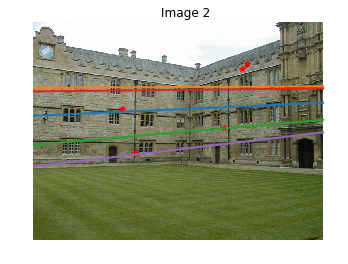

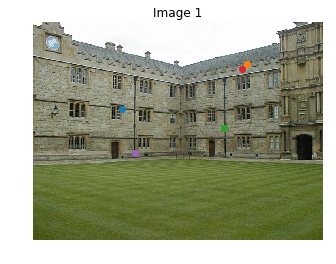

In [16]:
plt.figure()
plt.imshow(im2)
plt.title('Image 2')

# plot each line individually, this gives nice colors
for i in range(100, 105): 
    plot_epipolar_line(im2, F, x1[:, i], e)

plt.axis('off')
plt.figure()
plt.imshow(im1)
plt.title('Image 1')

# plot each point individually, this gives same colors as the lines 
for i in range(100, 105):
    plt.plot(x1[0, i], x1[1, i], 'o')
    plt.axis('off')

## Part II: 3D Model Reconstruction

### Load matched points
We provide a synthetic pair of images where accurate correspondences are known.
You don't have to replace this data.

In [8]:
left = np.array(Image.open(os.path.join('MatchedPoints','left.jpg')), dtype=np.float32).mean(2)/255
right = np.array(Image.open(os.path.join('MatchedPoints','right.jpg')), dtype=np.float32).mean(2)/255

Text(0.5,1,'Right image')

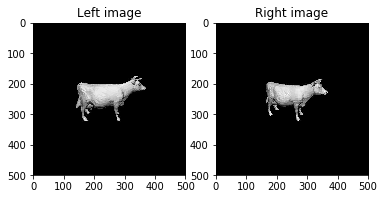

In [9]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

In [10]:
A = np.loadtxt('MatchedPoints/Matched_Points.txt')

In [11]:
M, N = A.shape
leftPoints = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
rightPoints = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)

### Calibration matrix and focal length from the given file

In [12]:
fl = 4;
I = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F

In [13]:
# TODO: Estimate fundamental matrix F (like in Part I)
F = eightPointsAlgorithm(leftPoints, rightPoints)
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

# TODO: Estimate essential matrix E from F
E = I.T * F * I

print('Estimated essential matrix: ')
print(E)

Estimated fundamental matrix: 
[[-6.76984374e-07 -3.90787849e-06  1.02848384e-03]
 [-4.94491514e-06  4.14993362e-07 -7.03036702e-03]
 [ 2.74737735e-03  9.53884223e-03 -9.99925486e-01]]
Estimated essential matrix: 
[[-0.07522048 -0.          0.        ]
 [-0.          0.04611037 -0.        ]
 [ 0.          0.         -0.99992549]]


### Compute rotation and translation between views

In [14]:
# TODO: Compute rotation and translation between views. Complete decomposeE
Il = np.linalg.solve(I, leftPoints)
Ir = np.linalg.solve(I, rightPoints)


# Note: You may try both E and -E just to be sure.
Pl, Pr = decomposeE(-E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

IndexError: too many indices for array

### Estimate the 3D points

In [ ]:
x3D = infer3D(Il, Ir, Pl, Pr)
ipv.quickscatter(x=x3D[0,:], y=x3D[1,:], z=x3D[2,:])